# Comment analysis
- Some search doesn't match properly: Praça Bartolomeu de Gusmão

# Objectives
1. Explore downloaded data
2. Data cleaning
3. Analysis of score of every place
4. Words analysis
5. Spatial distribution of scoring

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import nltk
import sqlite3
import os
import re
from datetime import datetime
import geopandas as gpd
import osmnx as ox
import folium
import numpy as np


In [2]:
print(os.getcwd(), os.listdir('./'))
os.chdir('./../')
print(os.getcwd(), os.listdir('./'))


/mnt/Datos/proyectospython/EspaciosVerdes/notebooks ['01_dowload_osm.ipynb', '02_EDA_scraping.ipynb', 'cache']
/mnt/Datos/proyectospython/EspaciosVerdes ['notebooks', '.git', 'data', 'scripts', 'cache', 'venv', 'documents', '.gitignore', 'REAME.md']


In [3]:
NOME_DB = "data/raw/scrapcomments.db"
with sqlite3.connect(NOME_DB) as connection:
    df = pd.read_sql('SELECT * FROM googleplaces', connection)

In [4]:
df.shape

(1598, 6)

In [5]:
df.head()

,index,url,search_word,Estrellas,Fecha,Comentario
0,0,https://www.google.com/maps/place/Parque+do+Es...,parque do escravote coimbra,5,há um ano,Um ótimo lugar para comer e uma trilha excelen...
1,1,https://www.google.com/maps/place/Parque+do+Es...,parque do escravote coimbra,5,há um mês,"Foi muito divertida, rir muito com minha mulhe..."
2,2,https://www.google.com/maps/place/Parque+do+Es...,parque do escravote coimbra,4,há um ano,Um sitio para quem mora perto fazer uma patusc...
3,3,https://www.google.com/maps/place/Parque+do+Es...,parque do escravote coimbra,2,há 5 meses,"Maltratado. Só placas de inaugurações, mas águ..."
4,4,https://www.google.com/maps/place/Parque+do+Es...,parque do escravote coimbra,4,há 2 anos,Um bom parque com várias mesas cobertas e uma ...


In [6]:
# 1598 - 801 = 797 Duplicates
df = df.drop_duplicates(subset=['url', 'Comentario'])
df.shape

(801, 6)

# Explore data

In [7]:
df['Estrellas'].value_counts()

Estrellas
5    418
4    223
3    112
2     26
1     22
Name: count, dtype: int64

In [8]:
df.dtypes

index           int64
url            object
search_word    object
Estrellas      object
Fecha          object
Comentario     object
dtype: object

In [9]:
df['url']

0       https://www.google.com/maps/place/Parque+do+Es...
1       https://www.google.com/maps/place/Parque+do+Es...
2       https://www.google.com/maps/place/Parque+do+Es...
3       https://www.google.com/maps/place/Parque+do+Es...
4       https://www.google.com/maps/place/Parque+do+Es...
                              ...                        
1464    https://www.google.com/maps/place/Parque+da+Qu...
1465    https://www.google.com/maps/place/Parque+da+Qu...
1466    https://www.google.com/maps/place/Parque+da+Qu...
1467    https://www.google.com/maps/place/Parque+da+Qu...
1468    https://www.google.com/maps/place/Parque+da+Qu...
Name: url, Length: 801, dtype: object

In [10]:
df['url'].iloc[0]

'https://www.google.com/maps/place/Parque+do+Escravote/@40.2479977,-8.4139518,17z/data=!4m8!3m7!1s0xd22feb336f9f8fd:0xf3de85a1b55b1b2e!8m2!3d40.2479977!4d-8.4113769!9m1!1b1!16s%2Fg%2F11c67wvpxp?entry=ttu&g_ep=EgoyMDI1MTEyMy4xIKXMDSoASAFQAw%3D%3D'

# Time series analysis

In [11]:
df['Fecha'].value_counts()

Fecha
há 6 anos              136
há 3 anos              101
há 2 anos               97
há 4 anos               70
há 7 anos               69
há um ano               63
há 8 anos               58
há 5 anos               42
Editado há 6 anos       17
há 3 meses              15
há 9 anos               13
há um mês               13
Editado há 3 anos       12
Editado há 2 anos       12
há 4 meses              10
há 5 meses               9
há 2 meses               8
Editado há 4 anos        8
Editado há 5 anos        7
há 7 meses               6
Editado há 8 anos        5
há 8 meses               4
há 10 meses              4
Editado há 7 anos        4
há 11 meses              3
há uma semana            2
Editado há um ano        2
há 9 meses               2
há 2 semanas             2
Editado há 6 meses       1
há 3 semanas             1
Editado há 10 meses      1
há 6 meses               1
há 4 dias                1
há 10 anos               1
Editado há 9 anos        1
Name: count, dtype: in

In [12]:
# Mapping words
MAPA_TIEMPO = {
    'years': ['ano', 'anos', 'año', 'años'],
    'months': ['mês', 'meses', 'mes'],
    'weeks': ['semana', 'semanas'],
    'days':   ['dia', 'dias', 'día', 'días'],
    'hours':  ['hora', 'horas'],  # Extra: por si aparecen horas
}

def convertir_fecha_dinamica(texto):
    """
    Convierte texto como 'há 6 anos' en un objeto datetime real
    usando extracción dinámica de números y unidades.
    """
    # 1. Normalización básica
    if pd.isna(texto): return pd.NaT
    # Pasamos a minúsculas y limpiamos espacios
    t = str(texto).lower().strip()
    
    # Fecha base (Hoy) normalizada a las 00:00:00
    hoy = pd.Timestamp.now().normalize()

    # 2. Extracción del VALOR (Entero)
    cantidad = 0
    
    # Caso especial: palabras textuales como "um" o "uma"
    if 'um ' in t or 'uma ' in t: # Espacio para no confundir con 'algUMa'
        cantidad = 1
    else:
        # Regex: Busca cualquier secuencia de dígitos (\d+)
        coincidencia = re.search(r'(\d+)', t)
        if coincidencia:
            cantidad = int(coincidencia.group(1))
        else:
            return pd.NaT # Si no hay número ni 'um', no podemos calcular

    # 3. Detección de la UNIDAD (Dinámica)
    # Recorremos nuestro diccionario de configuración
    for unidad_pandas, palabras_clave in MAPA_TIEMPO.items():
        # Verificamos si alguna palabra clave está en el texto
        if any(palabra in t for palabra in palabras_clave):
            
            # 4. Cálculo Matemático (Magia de Pandas)
            # Creamos un diccionario dinámico con el parámetro correcto
            # Equivale a decir: DateOffset(years=6) o DateOffset(months=3)
            kwargs = {unidad_pandas: cantidad}
            return hoy - pd.DateOffset(**kwargs)

    # Si llegamos aquí, detectamos número pero no la unidad (ej: "há 6 ???")
    return pd.NaT


In [13]:
# Apply custom function to extract time data
print("Calculando fechas...")
df['Fecha_Calculada'] = df['Fecha'].apply(convertir_fecha_dinamica)
df.head()

Calculando fechas...


,index,url,search_word,Estrellas,Fecha,Comentario,Fecha_Calculada
0,0,https://www.google.com/maps/place/Parque+do+Es...,parque do escravote coimbra,5,há um ano,Um ótimo lugar para comer e uma trilha excelen...,2024-12-02
1,1,https://www.google.com/maps/place/Parque+do+Es...,parque do escravote coimbra,5,há um mês,"Foi muito divertida, rir muito com minha mulhe...",2025-11-02
2,2,https://www.google.com/maps/place/Parque+do+Es...,parque do escravote coimbra,4,há um ano,Um sitio para quem mora perto fazer uma patusc...,2024-12-02
3,3,https://www.google.com/maps/place/Parque+do+Es...,parque do escravote coimbra,2,há 5 meses,"Maltratado. Só placas de inaugurações, mas águ...",2025-07-02
4,4,https://www.google.com/maps/place/Parque+do+Es...,parque do escravote coimbra,4,há 2 anos,Um bom parque com várias mesas cobertas e uma ...,2023-12-02


# Simple exploratory comments
## Word Cloud

In [14]:
# Descargamos las palabras vacías (solo la primera vez)
nltk.download('stopwords')

# Convertimos a string por si hay algún dato numérico suelto y eliminamos vacíos
df['Comentario'] = df['Comentario'].astype(str).fillna('')

# 2. DEFINIR STOPWORDS (Palabras a ignorar)
# Usamos la lista de español de NLTK y añadimos algunas propias que no aportan valor
stop_words_es = stopwords.words('portuguese')
# Añadimos palabras "basura" típicas de reviews que ensucian el gráfico
nuevas_stopwords = ['lar', 'sitio', 'ir', 'ver', 'mas', 'si', 'tan', 'parco', 'verde'] 
stop_words_es.extend(nuevas_stopwords)

[nltk_data] Downloading package stopwords to /home/bac/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
def generar_nube(texto_completo, titulo):
    wordcloud = WordCloud(
        width=800, 
        height=400,
        background_color='white',
        stopwords=stop_words_es,
        min_font_size=10
    ).generate(texto_completo)

    plt.figure(figsize=(10, 5), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(titulo, fontsize=20)
    plt.tight_layout(pad=0)
    plt.show()

Generando Nube de Palabras General...


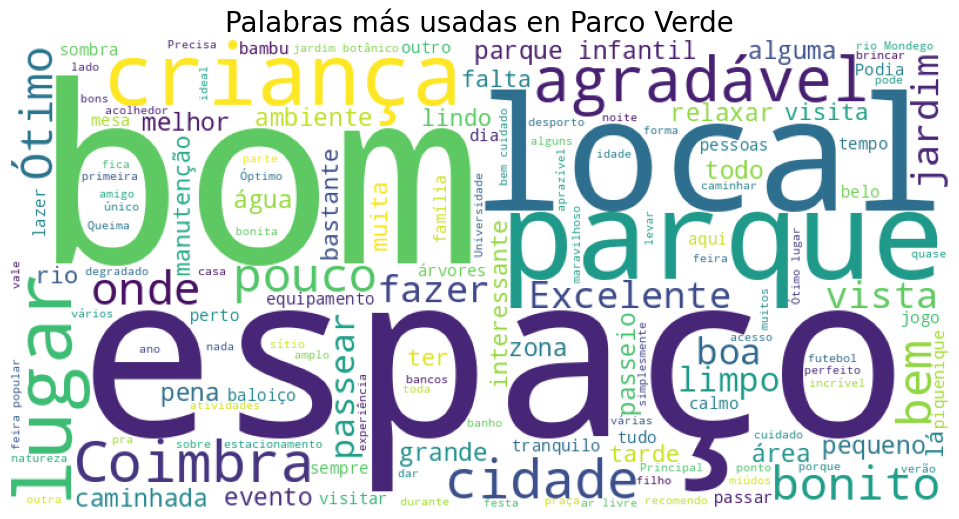

In [16]:
print("Generando Nube de Palabras General...")
texto_general = " ".join(review for review in df.Comentario)
generar_nube(texto_general, "Palabras más usadas en Parco Verde")

## B-Gram

In [17]:
def grafico_bigramas(corpus, n=10):
    # CountVectorizer counting pairs of words (ngram_range=(2,2))
    vec = CountVectorizer(ngram_range=(2, 2), stop_words=stop_words_es).fit(corpus)
    bag_of_words = vec.transform(corpus)
    
    # Sum of the word frequencies 
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    
    # Order frequency
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    # Get first n pair
    top_words = words_freq[:n]
    
    # Separamos para graficar
    x, y = zip(*top_words) # x=words, y=frequency
    
    plt.figure(figsize=(10, 6))
    plt.barh(x, y, color='skyblue')
    plt.gca().invert_yaxis()
    plt.title('Top 10 Pares de Palabras (Bigramas) más comunes')
    plt.xlabel('Frecuencia')
    plt.show()

Generando Bigramas...


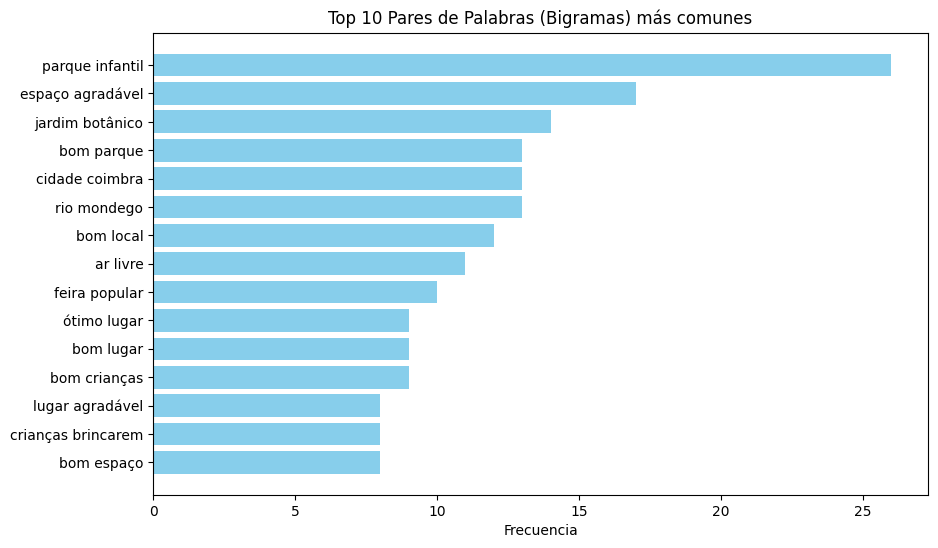

In [18]:
print("Generando Bigramas...")
grafico_bigramas(df['Comentario'], n=15)

# Time series

In [19]:
df.head()

,index,url,search_word,Estrellas,Fecha,Comentario,Fecha_Calculada
0,0,https://www.google.com/maps/place/Parque+do+Es...,parque do escravote coimbra,5,há um ano,Um ótimo lugar para comer e uma trilha excelen...,2024-12-02
1,1,https://www.google.com/maps/place/Parque+do+Es...,parque do escravote coimbra,5,há um mês,"Foi muito divertida, rir muito com minha mulhe...",2025-11-02
2,2,https://www.google.com/maps/place/Parque+do+Es...,parque do escravote coimbra,4,há um ano,Um sitio para quem mora perto fazer uma patusc...,2024-12-02
3,3,https://www.google.com/maps/place/Parque+do+Es...,parque do escravote coimbra,2,há 5 meses,"Maltratado. Só placas de inaugurações, mas águ...",2025-07-02
4,4,https://www.google.com/maps/place/Parque+do+Es...,parque do escravote coimbra,4,há 2 anos,Um bom parque com várias mesas cobertas e uma ...,2023-12-02


In [20]:
df['Estrellas'] = df['Estrellas'].astype(int)

In [21]:
analisis_temporal = df.groupby(pd.Grouper(key='Fecha_Calculada', freq='M')).agg({'Estrellas': 'mean'})
print(analisis_temporal)

                 Estrellas
Fecha_Calculada           
2015-12-31        4.000000
2016-01-31             NaN
2016-02-29             NaN
2016-03-31             NaN
2016-04-30             NaN
...                    ...
2025-07-31        4.111111
2025-08-31        4.100000
2025-09-30        4.600000
2025-10-31        4.500000
2025-11-30        4.315789

[120 rows x 1 columns]


/tmp/ipykernel_135480/1224104953.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  analisis_temporal = df.groupby(pd.Grouper(key='Fecha_Calculada', freq='M')).agg({'Estrellas': 'mean'})


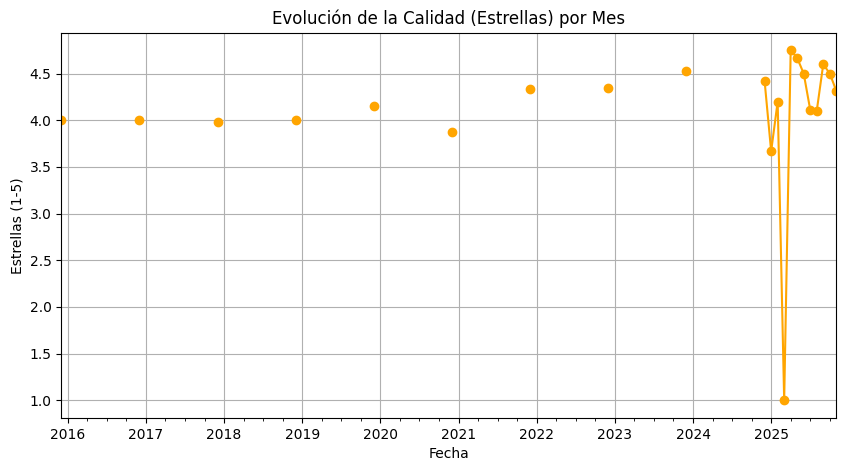

In [22]:
# Plot of stars over the time column
analisis_temporal['Estrellas'].plot(kind='line', marker='o', color='orange', figsize=(10,5))

plt.title("Evolución de la Calidad (Estrellas) por Mes")
plt.ylabel("Estrellas (1-5)")
plt.xlabel("Fecha")
plt.grid(True)
plt.show()

# Spatial comments analysis

In [23]:
df.head()

,index,url,search_word,Estrellas,Fecha,Comentario,Fecha_Calculada
0,0,https://www.google.com/maps/place/Parque+do+Es...,parque do escravote coimbra,5,há um ano,Um ótimo lugar para comer e uma trilha excelen...,2024-12-02
1,1,https://www.google.com/maps/place/Parque+do+Es...,parque do escravote coimbra,5,há um mês,"Foi muito divertida, rir muito com minha mulhe...",2025-11-02
2,2,https://www.google.com/maps/place/Parque+do+Es...,parque do escravote coimbra,4,há um ano,Um sitio para quem mora perto fazer uma patusc...,2024-12-02
3,3,https://www.google.com/maps/place/Parque+do+Es...,parque do escravote coimbra,2,há 5 meses,"Maltratado. Só placas de inaugurações, mas águ...",2025-07-02
4,4,https://www.google.com/maps/place/Parque+do+Es...,parque do escravote coimbra,4,há 2 anos,Um bom parque com várias mesas cobertas e uma ...,2023-12-02


In [24]:
df['url'].iloc[0]

'https://www.google.com/maps/place/Parque+do+Escravote/@40.2479977,-8.4139518,17z/data=!4m8!3m7!1s0xd22feb336f9f8fd:0xf3de85a1b55b1b2e!8m2!3d40.2479977!4d-8.4113769!9m1!1b1!16s%2Fg%2F11c67wvpxp?entry=ttu&g_ep=EgoyMDI1MTEyMy4xIKXMDSoASAFQAw%3D%3D'

In [25]:
# Extract coordinates
# (?P<Latitud>...) assign a new column
patron = r'@(?P<Latitud>-?\d+\.\d+),(?P<Longitud>-?\d+\.\d+)'

# 3. Aplicamos la extracción mágica
# Esto busca el patrón en cada fila y separa los grupos en nuevas columnas
coordenadas = df['url'].str.extract(patron)

# 4. Convertimos a números (porque se extraen como texto)
coordenadas = coordenadas.astype(float)

# 5. Unimos las nuevas columnas a tu DataFrame original
df_final = pd.concat([df, coordenadas], axis=1)
df_final.head()

,index,url,search_word,Estrellas,Fecha,Comentario,Fecha_Calculada,Latitud,Longitud
0,0,https://www.google.com/maps/place/Parque+do+Es...,parque do escravote coimbra,5,há um ano,Um ótimo lugar para comer e uma trilha excelen...,2024-12-02,40.247998,-8.413952
1,1,https://www.google.com/maps/place/Parque+do+Es...,parque do escravote coimbra,5,há um mês,"Foi muito divertida, rir muito com minha mulhe...",2025-11-02,40.247998,-8.413952
2,2,https://www.google.com/maps/place/Parque+do+Es...,parque do escravote coimbra,4,há um ano,Um sitio para quem mora perto fazer uma patusc...,2024-12-02,40.247998,-8.413952
3,3,https://www.google.com/maps/place/Parque+do+Es...,parque do escravote coimbra,2,há 5 meses,"Maltratado. Só placas de inaugurações, mas águ...",2025-07-02,40.247998,-8.413952
4,4,https://www.google.com/maps/place/Parque+do+Es...,parque do escravote coimbra,4,há 2 anos,Um bom parque com várias mesas cobertas e uma ...,2023-12-02,40.247998,-8.413952


In [26]:
analisis_temporal = df_final.groupby(by='url').agg({'Estrellas': 'mean',
                                              'Latitud': 'max',
                                              'Longitud': 'max',
                                              'search_word': 'max'})

In [27]:
analisis_temporal.head()

,Estrellas,Latitud,Longitud,search_word
url,,,,
"https://www.google.com/maps/place/Bambuzal/@40.2058621,-8.4412277,15z/data=!4m8!3m7!1s0xd22f970eaf9e2fb:0x3dc4ececa7d36412!8m2!3d40.2058636!4d-8.4227738!9m1!1b1!16s%2Fg%2F11h7bm1dkg?entry=ttu&g_ep=EgoyMDI1MTEyMy4xIKXMDSoASAFQAw%3D%3D",4.533333,40.205862,-8.441228,bambuzal coimbra
"https://www.google.com/maps/place/Casa+das+Artes+Bissaya+Barreto/@40.2075055,-8.423581,17z/data=!4m8!3m7!1s0xd22f90b8a0eb1eb:0xa9ef3bb1924913c4!8m2!3d40.2075055!4d-8.4210061!9m1!1b1!16s%2Fg%2F11c533k7_k?entry=ttu&g_ep=EgoyMDI1MTEyMy4xIKXMDSoASAFQAw%3D%3D",4.733333,40.207506,-8.423581,jardim da casa das artes coimbra
"https://www.google.com/maps/place/Casa+do+Sal/@40.2191565,-8.4555006,15z/data=!4m8!3m7!1s0xd22f91c37a4ded9:0xccb6aa5a0f881e81!8m2!3d40.219158!4d-8.4370467!9m1!1b1!16s%2Fg%2F11g8w0n546?entry=ttu&g_ep=EgoyMDI1MTEyMy4xIKXMDSoASAFQAw%3D%3D",3.966667,40.219156,-8.455501,parque infantil da casa do sal coimbra
"https://www.google.com/maps/place/Jardim+Bot%C3%A2nico+da+Universidade+de+Coimbra/@40.205491,-8.4233179,17z/data=!4m8!3m7!1s0xd22f9a0875f68c9:0xbf58f2303575d92e!8m2!3d40.205491!4d-8.420743!9m1!1b1!16s%2Fg%2F121_zgq5?entry=ttu&g_ep=EgoyMDI1MTEyMy4xIKXMDSoASAFQAw%3D%3D",4.777778,40.205491,-8.423318,jardim botânico da universidade de coimbra coi...
"https://www.google.com/maps/place/Jardim+Cidade+de+Halle/@40.2229171,-8.4378289,17z/data=!4m8!3m7!1s0xd22f91ed60e1279:0x449c16a13a7cb373!8m2!3d40.2229171!4d-8.435254!9m1!1b1!16s%2Fg%2F11hb4266gz?entry=ttu&g_ep=EgoyMDI1MTEyMy4xIKXMDSoASAFQAw%3D%3D",4.000000,40.222917,-8.437829,jardim cidade de halle coimbra


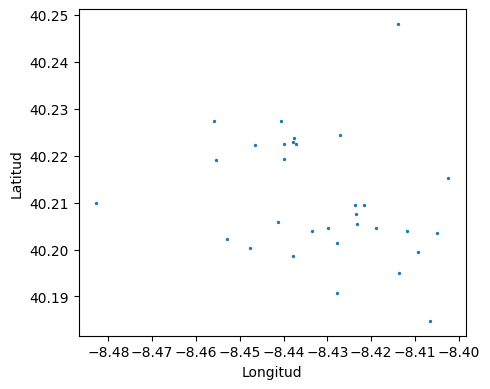

In [28]:
x_feat, y_feat = 'Longitud', 'Latitud'
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.scatter(analisis_temporal[x_feat], analisis_temporal[y_feat], s=2)
plt.ylabel(y_feat)
plt.xlabel(x_feat)
fig.tight_layout()
plt.show()

In [29]:
file_name = "data/raw/espacios_verdes_coimbra.geojson"
gdf_parques = gpd.read_file(file_name)
gdf = gdf_parques.loc[gdf_parques['name'].notna(), :].copy()
gdf['name'].str.lower().to_list()
lon, lat = np.mean(gdf_parques["geometry"].centroid.x), np.mean(gdf_parques["geometry"].centroid.y)

/tmp/ipykernel_135480/849045973.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lon, lat = np.mean(gdf_parques["geometry"].centroid.x), np.mean(gdf_parques["geometry"].centroid.y)


In [33]:
# @tag:workspaceTrust
m = folium.Map(location=[lat, lon], zoom_start=10, tiles='OpenStreetMap')

# --- PARTE A: TU CÓDIGO (POLÍGONOS / BARRIOS) ---
# Iteramos sobre el GeoDataFrame (gdf)
for _, r in gdf.iterrows():
    # Simplificamos la geometría para que el mapa cargue rápido
    sim_geo = gpd.GeoSeries(r["geometry"]).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    
    # Creamos la capa GeoJson
    geo_j_layer = folium.GeoJson(
        data=geo_j, 
        style_function=lambda x: {"fillColor": "orange", "color": "orange", "weight": 1, "fillOpacity": 0.3}
    )
    
    # Añadimos popup con el nombre de la zona
    folium.Popup(r["name"]).add_to(geo_j_layer)
    geo_j_layer.add_to(m)

# --- PARTE B: NUEVO CÓDIGO (PUNTOS DE COORDENADAS) ---
# Iteramos sobre el DataFrame de coordenadas (df)
for index, row in analisis_temporal.iterrows():
    folium.Marker(
        location=[row['Latitud'], row['Longitud']],
        tooltip=row['search_word'], # Aparece al pasar el ratón (hover)
        popup=folium.Popup(f"<b>{row['search_word']} ,  {row['Estrellas']}</b>", max_width=300), # Aparece al hacer clic
        icon=folium.Icon(color="blue", icon="info-sign") # Icono azul
    ).add_to(m)
m

In [ ]:
x_feat, y_feat, size = 'lon', 'lat', 'uso_bici'
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax = ax.scatter(df2gm[x_feat], df2gm[y_feat], s=(df2gm[size]+1)**8, c=df2gm[size], cmap='viridis')
plt.ylabel(y_feat)
plt.xlabel(x_feat)
fig.tight_layout()
cbar = plt.colorbar(ax)
cbar.set_label(size)
plt.show()

In [31]:
# Save data in processed folder
analisis_temporal.loc[:, ['search_word', 'Estrellas', 'Longitud', 'Latitud']].to_csv('data/processed/parcoverde.csv', index=False)

# END